# Analyzing simulation data from HOOMD-blue at runtime

The following script shows how to use `freud` to compute the radial distribution function $g(r)$ on data generated by the molecular dynamics simulation engine HOOMD-blue _during a simulation run_.

**Generally, most users will want to run analyses as _post-processing_ steps, on the saved frames of a particle trajectory file.** However, it is possible to use analysis callbacks in HOOMD-blue to compute and log quantities at runtime, too. By using analysis methods at runtime, it is possible to stop a simulation early or change the simulation parameters dynamically according to the analysis results.

HOOMD-blue can be installed with `conda install -c conda-forge hoomd`.

The simulation script runs a Monte Carlo simulation of spheres, with outputs parsed with `numpy.genfromtxt`.

In [1]:
%matplotlib inline
import freud
import hoomd
import h5py
import itertools
import matplotlib.pyplot as plt
import numpy as np
from hoomd import hpmc

/home/tomwalt/mambaforge/envs/freud-examples/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
def make_simple_cubic_snapshot(a, n):
    """Make a snapshot with a simple cubic lattice.

    Args:
        a (float): Lattice spacing
        n (int): Number of particles

    Returns:
        hoomd.Snapshot: The initial system snapshot.
    """
    k = int(np.ceil(n**(1/3)))
    L = k * a
    x = np.linspace(-L / 2, L / 2, k, endpoint=False)
    position = list(itertools.product(x, repeat=3))
    position = position[:n]

    snap = hoomd.Snapshot()
    snap.particles.N = n
    snap.particles.types=['A']
    snap.particles.typeid[:] = [0] * n
    snap.particles.position[:] = position
    snap.configuration.box = [L, L, L, 0, 0, 0]

    return snap


class FreudRDFCalc(hoomd.custom.Action):
    """Compute RDF periodically as the simulation progresses."""

    def __init__(self, sim, rdf):
        self._sim = sim
        self._rdf = rdf

    def act(self, timestep):
        snap = self._sim.state.get_snapshot()
        self._rdf.compute(system=snap, reset=False)


class FreudW6Calc(hoomd.custom.Action):
    """Compute w6 for logging during a simulation."""
    
    def __init__(self, sim, w6):
        self._sim = sim
        self._w6 = w6

    @hoomd.logging.log
    def w6(self):
        """Calculate w6 order parameter."""
        snap = self._sim.state.get_snapshot()
        self._w6.compute(snap, neighbors=dict(num_neighbors=12))
        return np.mean(w6.particle_order)

    def act(self, timestep):
        pass
        

In [3]:
# set up simulation
sim = hoomd.Simulation(device=hoomd.device.CPU())
sim.create_state_from_snapshot(make_simple_cubic_snapshot(a=1.0, n=1000))
sim.seed = 42
mc = hpmc.integrate.Sphere(default_d=0.1, default_a=0.1)
mc.shape["A"] = dict(diameter=0.5)
sim.operations.integrator = mc

# freud-related classes
rdf = freud.density.RDF(bins=50, r_max=4)
w6 = freud.order.Steinhardt(l=6, wl=True)
rdf_calc = FreudRDFCalc(sim, rdf)
w6_calc = FreudW6Calc(sim, w6)

# Equilibrate the system a bit before accumulating the RDF.
sim.run(1e4)

# add logger/w6/rdf calculations to the simulation
logger = hoomd.logging.Logger(hoomd.write.HDF5Log.accepted_categories)
logger.add(w6_calc, quantities=['w6'])
logger.add(sim, quantities=['timestep'])
hdf5_writer = hoomd.write.HDF5Log(
    trigger=100,
    filename="w6_data.h5",
    mode='w',
    logger=logger
)
sim.operations.writers.append(hdf5_writer)

rdf_action = hoomd.write.CustomWriter(action=rdf_calc, trigger=100)
sim.operations.writers.append(rdf_action)

sim.run(1e4)
hdf5_writer.flush()

# Store the computed RDF in a file
np.savetxt(
    "rdf.csv", np.vstack((rdf.bin_centers, rdf.rdf)).T, delimiter=",", header="r, g(r)"
)

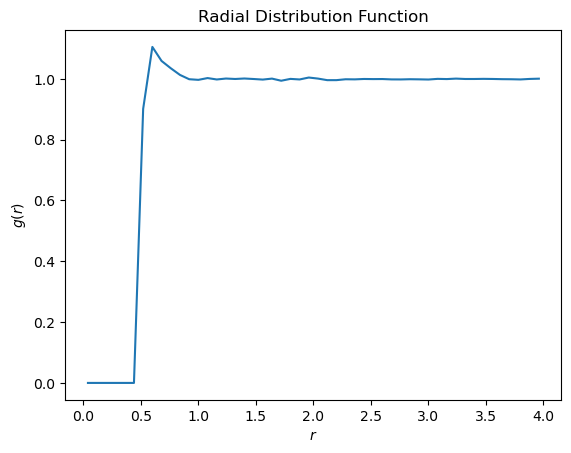

In [4]:
rdf_data = np.genfromtxt("rdf.csv", delimiter=",")
plt.plot(rdf_data[:, 0], rdf_data[:, 1])
plt.title("Radial Distribution Function")
plt.xlabel("$r$")
plt.ylabel("$g(r)$")
plt.show()

/                        Group
/hoomd-data              Group
/hoomd-data/FreudW6Calc  Group
/hoomd-data/FreudW6Calc/w6 Dataset {100/Inf}
/hoomd-data/Simulation   Group
/hoomd-data/Simulation/timestep Dataset {100/Inf}


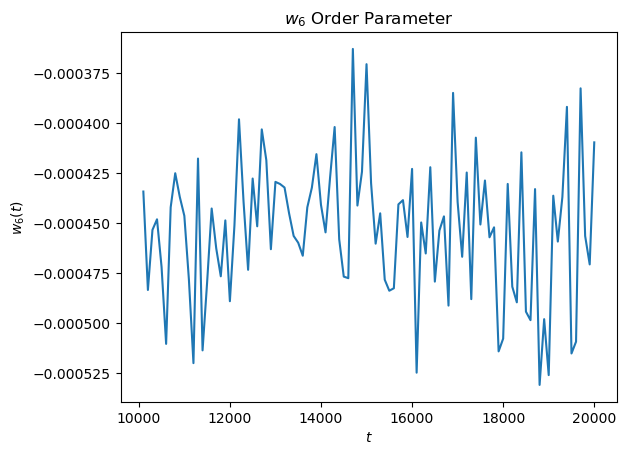

In [5]:
sim.operations.writers.remove(hdf5_writer)
w6_data = h5py.File("w6_data.h5", 'r')
plt.plot(w6_data['hoomd-data/Simulation/timestep'][:], w6_data['hoomd-data/FreudW6Calc/w6'][:])
plt.title("$w_6$ Order Parameter")
plt.xlabel("$t$")
plt.ylabel("$w_6(t)$")
plt.show()